In [67]:
import matplotlib.pyplot as plt

In [1]:
data_file = "../dataset/shakespeare.txt"

with open(data_file, 'r') as f:
    data_raw = f.read()

In [24]:
raw_bytes = data_raw.encode('utf-8')
raw_bytes = list(map(lambda x: int(x), raw_bytes))

In [47]:
print(len(data_raw), len(raw_bytes), len(data_raw)-len(raw_bytes))

1115394 1115394 0


In [41]:
def get_stats(data):
    stats = {}
    for pair in zip(data[:-1], data[1:]):
        stats[pair] = stats.get(pair, 0) + 1
    
    pair_stats = [(f, p) for p, f in stats.items()]
    pair_stats = sorted(pair_stats, reverse=True) 

    return pair_stats

In [43]:
pair_stats = get_stats(raw_bytes)
pair_stats[:10]

[(27643, (101, 32)),
 (23837, (32, 116)),
 (22739, (116, 104)),
 (18203, (104, 101)),
 (16508, (116, 32)),
 (15364, (115, 32)),
 (14165, (100, 32)),
 (14098, (44, 32)),
 (13541, (32, 97)),
 (12730, (111, 117))]

In [44]:
top_pair = pair_stats[0][1]

In [48]:
def merge(data, pair, pair_idx):
    
    new_data = []
    idx = 0
    while True:
        # check if pair is pair
        if data[idx:idx+2] == list(pair):
            new_data.append(pair_idx)
            idx += 2
        else:
            new_data.append(data[idx])
            idx += 1
        
        if idx >= len(data):
            break

    return new_data

In [50]:
new = merge(raw_bytes, top_pair, 256)
print(len(data_raw), len(new), len(data_raw)-len(new))

1115394 1087751 27643


In [79]:
def train_tokenizer(raw_idx, num_iter):
    ids_map = []
    compress_curve = []

    target_idx = list(raw_idx) # copy
    for iter in range(num_iter):
        pair_stats = get_stats(target_idx)
        top_pair_freg, top_pair = pair_stats[0]
        if top_pair_freg <= 1:
            break

        target_idx = merge(target_idx, top_pair, len(ids_map)+256)
        ids_map.append(top_pair)

        compress_curve.append(len(raw_idx)/len(target_idx))

    print("stop at iter", iter+1, "/", num_iter)
    print("number of ids_map", len(ids_map))
    print("initial data size:", len(raw_idx))
    print("final data size:", len(target_idx))
    print("size difference:", len(raw_idx)-len(target_idx))
    print("compress ratio:", len(raw_idx)/len(target_idx))

    return ids_map, target_idx, compress_curve

In [80]:
ids_map, target_idx, compress_curve = train_tokenizer(raw_bytes, 100)

stop at iter 100 / 100
number of ids_map 100
initial data size: 1115394
final data size: 688066
size difference: 427328
compress ratio: 1.6210567009560128


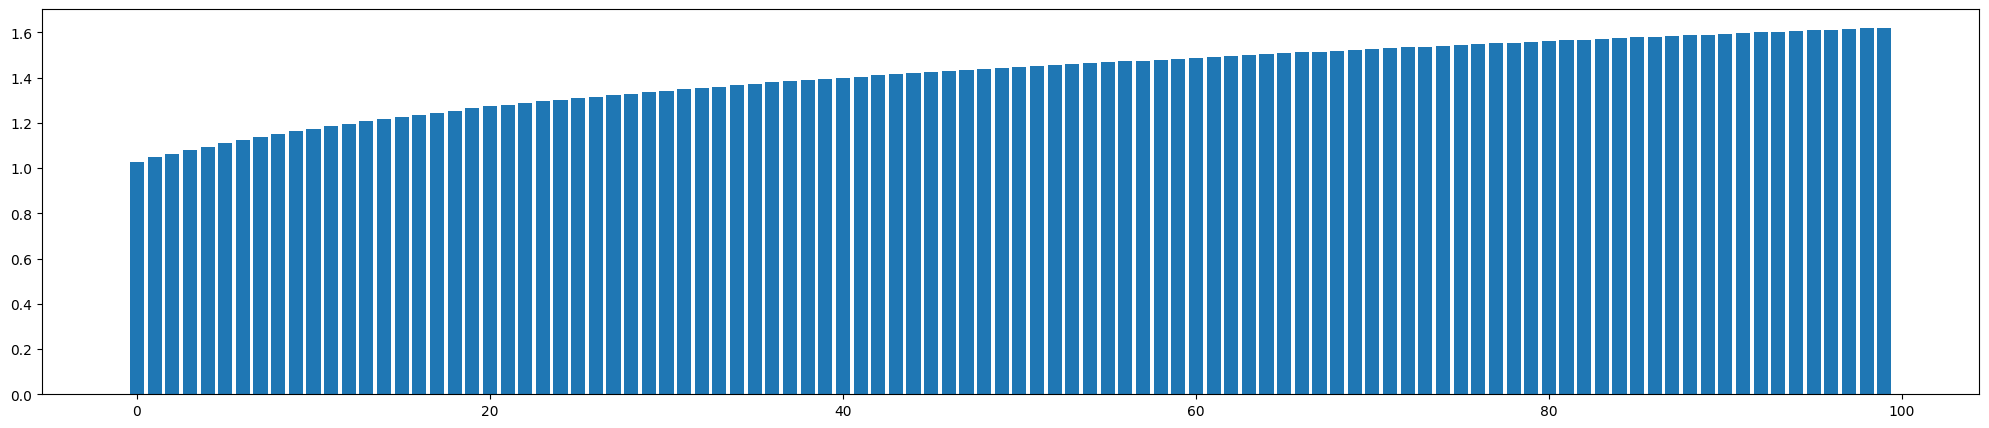

In [82]:
plt.figure(figsize=(25, 5))
plt.bar(list(range(len(compress_curve))), compress_curve)
plt.show()

In [105]:
def encode_id(raw_idx, ids_map):
    target_idx = list(raw_idx)

    for idx, pair in enumerate(ids_map):
        target_idx = merge(target_idx, pair, idx+256)

    return target_idx

def encode(input_str, ids_map):
    raw_bytes = input_str.encode('utf-8')
    raw_bytes = list(map(lambda x: int(x), raw_bytes))

    return encode_id(raw_bytes, ids_map)

# target_idx = encode_id(raw_bytes, ids_map)

# print("initial data size:", len(raw_bytes))
# print("final data size:", len(target_idx))
# print("size difference:", len(raw_bytes)-len(target_idx))
# print("compress ratio:", len(raw_bytes)/len(target_idx))

In [104]:
def decode_id(raw_idx, ids_map):

    target_idx = list(raw_idx)
    for idx, pair in reversed(list(enumerate(ids_map))):
        new_idx = []
        for i in target_idx:
            if i == idx+256:
                new_idx.extend(pair)
            else:
                new_idx.append(i)
        target_idx = new_idx
    
    return target_idx

def decode(raw_idx, ids_map):
    decoded_idx = decode_id(raw_idx, ids_map)
    decoded_bytes = b"".join([bytes([b]) for b in decoded_idx])
    return decoded_bytes.decode("utf-8")

# decoded_idx = decode_id(target_idx, ids_map)

# print("initial data size:", len(raw_bytes))
# print("final data size:", len(decoded_idx))
# print("size difference:", len(raw_bytes)-len(decoded_idx))
# print("compress ratio:", len(raw_bytes)/len(decoded_idx))

In [108]:
len("Hello how are you?".encode("utf-8")), len(encode("Hello how are you?", ids_map))

(18, 11)

In [109]:
decode(encode("Hellow how are you?", ids_map), ids_map)

'Hellow how are you?'

In [112]:
import json

In [113]:
with open("tokens.json", "w") as f:
    json.dump(ids_map, f)

In [114]:
import json

def get_stats(data):
    stats = {}
    for pair in zip(data[:-1], data[1:]):
        stats[pair] = stats.get(pair, 0) + 1
    
    pair_stats = [(f, p) for p, f in stats.items()]
    pair_stats = sorted(pair_stats, reverse=True) 

    return pair_stats

def merge(data, pair, pair_idx):
    
    new_data = []
    idx = 0
    while True:
        # check if pair is pair
        if data[idx:idx+2] == list(pair):
            new_data.append(pair_idx)
            idx += 2
        else:
            new_data.append(data[idx])
            idx += 1
        
        if idx >= len(data):
            break

    return new_data

class Tokenizer:

    def __init__(self, token_path):
        self._token_path = token_path
        self.load(self._token_path)

    def _encode(self, raw_idx: list[int]) -> list[int]:
        target_idx = list(raw_idx)

        for idx, pair in enumerate(self.ids_map):
            target_idx = merge(target_idx, pair, idx+256)

        return target_idx

    def encode(self, text: str) -> list[int]:
        raw_bytes = text.encode('utf-8')
        raw_bytes = list(map(lambda x: int(x), raw_bytes))
        return self._encode(raw_bytes)

    def _decode(self, raw_idx: list[int]) -> list[int]:
        target_idx = list(raw_idx)
        for idx, pair in reversed(list(enumerate(self.ids_map))):
            new_idx = []
            for i in target_idx:
                if i == idx+256:
                    new_idx.extend(pair)
                else:
                    new_idx.append(i)
            target_idx = new_idx
        
        return target_idx

    def decode(self, raw_idx: list[int]) -> str:
        decoded_idx = self._decode(raw_idx)
        decoded_bytes = b"".join([bytes([b]) for b in decoded_idx])
        return decoded_bytes.decode("utf-8")

    def train(self, raw_idx, num_iter=100):
        ids_map = []
        compress_curve = []

        target_idx = list(raw_idx) # copy
        for iter in range(num_iter):
            pair_stats = get_stats(target_idx)
            top_pair_freg, top_pair = pair_stats[0]
            if top_pair_freg <= 1:
                break

            target_idx = merge(target_idx, top_pair, len(ids_map)+256)
            ids_map.append(top_pair)

            compress_curve.append(len(raw_idx)/len(target_idx))

        print("stop at iter", iter+1, "/", num_iter)
        print("number of ids_map", len(ids_map))
        print("initial data size:", len(raw_idx))
        print("final data size:", len(target_idx))
        print("size difference:", len(raw_idx)-len(target_idx))
        print("compress ratio:", len(raw_idx)/len(target_idx))

        # target_idx, compress_curve
        self.ids_map = ids_map
    
    def save(self, target_path):

        with open(target_path, "w") as f:
            json.dump(self.ids_map, f)

    def load(self, target_path):

        with open(target_path, "r") as f:
            self.ids_map = json.load(f)

        # convert pair to tuple
        self.ids_map = [(a, b) for a, b in self.ids_map]

tokenizer = Tokenizer("tokens.json")

In [117]:
t = "hello there, welcome to the world of llm"
print(len(t), len(tokenizer.encode(t)))
tokenizer.decode(tokenizer.encode(t))

40 21


'hello there, welcome to the world of llm'